In [1]:
import nltk
import numpy as np
import networkx as nx
import numpy as np
import sqlite3
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
import spacy
from collections import Counter
from nltk.corpus import stopwords
from nltk.cluster.util import cosine_distance
import datasketch
import graphviz

# A Deep Dive on Text Summarization

For my final capstone project I chose to take a look more closely at the topic of text summarization. The scope of this particular topic is quite broad, and there are many different approaches to text summarization. In my project, I will cover some of the simpler methods of summarizing with code that I've created as well as taking a look at the more advanced and well maintained text summarization projects out there.

### Extractive Summarization vs Abstractive Summarization

The topic of text summarization cannot be broached without talking about the two different schools. As alluded to in the heading for this explanation, those two schools are: extractive and abstractive. Extractive summarization is the simpler of the two and the method that I will focus on for the pipelines that I construct. To discuss their functionality and differences specifically:

Extractive Summarization: Algorithmically identifies the most informative sentences in a body of text, and sticks them together to generate a summary.

Abstractive Summarization: Algorithmically selects sentences that are concise and semantically related, and sticks them together to generate a summary.

Each school of summarization has its own advantages and disadvantages, though in general extractive is more light-weight and less refined while abstractive is more complex and computationally intensive - but produces summaries a little bit more like a human would.

Because abstractive summarization is a bit unwieldy for the computational power that I have available to me, my focus will be on extractive summarization and the different ways of approaching it.

## A Look at the Data

Before we roll up our sleeves and get into the work of text summarization, let's first begin by taking a look at our data set.

In [2]:
# importing the database - note that I happened to save the database onto my desktop, you'll have to make sure to use the
# correct directory to wherever you save the database to
path = 'C:\\Users\\Aaron\\Desktop\\'
database = path + 'news_articles.db'
cnx = sqlite3.connect(database)

news = pd.read_sql('SELECT * FROM longform', cnx)

In [3]:
news['publication'].value_counts()

New York Times         30257
Breitbart              23791
New York Post          18144
Reuters                15055
CNN                    14288
Washington Post        12051
NPR                    12001
Buzzfeed News          10699
Guardian                9920
Los Angeles Times       9036
Business Insider        8344
Atlantic                7386
National Review         6258
Talking Points Memo     5323
Vox                     4953
Fox News                4384
New Inquiry             3305
Verge                   1225
Name: publication, dtype: int64

In [4]:
news['section'].value_counts().head(20)

2016             9484
2017             8593
article          6258
news             5510
politics         3210
world            3188
thetwo-way       3050
livewire         2691
us-news          2256
opinions         1905
edblog           1291
health-shots     1062
us                923
commentisfree     852
sport             751
lifestyle         726
parallels         703
thesalt           675
goatsandsoda      648
film              587
Name: section, dtype: int64

In [5]:
news.shape[0]

204135

Here we have a database of news articles from a variety of different online publications, covering a wide array of topics. I'll pull some articles from this database, convert them into different file formats, and feed them into our modeling pipeline to generate a summary. I'll select articles from different topics so that the summarizer can be gauged on multiple styles of article.

# Summarizing Techniques

In this workbook, I'll take a look at python implementations for 5 seperate summarization techniques. Extractive summarization can be reduced to 3 basic steps: 1) splitting the document into sentences, 2) comparing similarity between those sentences, and 3) ranking sentences and returning them in ranked order. The differences between extractive summarization techniques reside almost entirely in that second step - figuring out exactly how to measure similarity in those sentences. With that in mind, let's take a look at a few of the many different ways to tackle this particular question.

### Cosine Distance

The approach that extractive summarization takes is always the same, we need to to split up our document into sentences and then rank those sentences on their importance. The first metric for determining importance that I've chosen is cosine distance. Essentially, sentences are converted into count vectors and the cosine of the angle those two vectors create is determined. It is a metric for orientation only, and does not take magnitude into account. Cosine of the two angles is the cosine similarity, which is subtracted from 1 to give us cosine distance. Finally, TextRank is applied to score each sentence based on how similar it is to other sentences, and a summary is generated with as many sentences as the user decides.

In [6]:
# Step 1 - prepare the text file to be sent through the pipeline
def read_article(file_name):
    # open the text file and read it into python
    file = open(file_name)
    filedata = file.readlines()
    cleaned = []

    # split the text up and rejoin it to get rid of any whitespace or strange indentations
    for article in filedata:
        sa = article.split()
        rj = ' '.join(sa)
        cleaned.append(rj)

    # split up the article into sentences based on punctuation    
    article = re.split('[?.!]', cleaned[0])
    sentences = []

    # remove any non-letter/digit character
    for sentence in article:
        sentences.append(sentence.replace("[^a-zA-Z\d]", ""))
        
    return sentences

In [7]:
# Step 2 - convert the sentences into vectors and compare them against one another: in this case with cosine distance
def sentence_vectorizer_cosine(sent1, sent2, stopwords=None):
    if stopwords is None:
        stopwords = []

    # make all the text lowercase in both sentences
    sent1 = [word.lower() for word in sent1]
    sent2 = [word.lower() for word in sent2]
    
    # find the total set of unique words in both sentences
    all_words = list(set(sent1 + sent2))

    # create empty vectors
    vector1 = [0] * len(all_words)
    vector2 = [0] * len(all_words)
 
    # ignoring stopwords, place a boolean into the vector if the word exists in that vector's sentence
    for word in sent1:
        if word in stopwords:
            continue
        vector1[all_words.index(word)] += 1
 
    # do the same with the second sentence
    for word in sent2:
        if word in stopwords:
            continue
        vector2[all_words.index(word)] += 1
 
    # using cosine similarity, determine how similar the two vectors (and therefore, sentences) are to one another
    return 1- cosine_distance(vector1, vector2)
 

In [8]:
# Step 3 - create a similarity matrix to quickly compare vectors to one another
def similarity_matrix(sentences, stop_words):
    #build an empty matrix
    similarity_matrix = np.zeros((len(sentences), len(sentences)))
 
    # ignoring identical sentences, calculate cosine similarity for each permutation of vectors - and load it into our empty matrix
    for index1 in range(len(sentences)):
        for index2 in range(len(sentences)):
            if index1 == index2:
                continue 
            similarity_matrix[index1][index2] = sentence_vectorizer_cosine(sentences[index1], sentences[index2], stop_words)

    return similarity_matrix

In [9]:
# Step 4 - rank sentences based on similarity, and generate a summary
def summarize_cosine(file_name, top_n):
    stop_words = stopwords.words('english')
    summary = []

    # read text file and split into sentences
    sentences =  read_article(file_name)

    # generate similarity matrix
    sentence_similarity_matrix = similarity_matrix(sentences, stop_words)

    # utilize textrank to score similarity
    sentence_similarity_graph = nx.from_numpy_array(sentence_similarity_matrix)
    scores = nx.pagerank(sentence_similarity_graph)

    # sort the sentence similarity scores and rank them
    ranked_sentence = sorted(((scores[i],s) for i,s in enumerate(sentences)), reverse=True)       

    # create the summary by joining n top ranked sentences
    for i in range(top_n):
        summary.append("".join(ranked_sentence[i][1]))
        
    summarized_text = '. '.join(summary)

    # output ranked sentences and summarized text
    print("Ranked sentences:", ranked_sentence)
    print("Summarized Text: \n", summarized_text)
    
    return summarized_text

In [10]:
tv_cos = summarize_cosine('tv.txt', 5)

Ranked sentences: [(0.011244604025374177, "' And never more so than in Showtime’s new series revival, some spoilers ahead through episode 4 of season 3 of Twin Peaks"), (0.010117066481843927, ' It’s natural for us to want to return to a mode where he can actively participate in his own story, where he’s helping solve its mysteries, instead of acting as its biggest conundrum'), (0.010096285405780926, ' But in the opening episode, Dale Cooper was still where the show left him in 1991: trapped in the spirit domain known as the Black Lodge, at the mercy of incomprehensible forces that behave in erratic, alien ways'), (0.010089582843291473, ' The knowledge that Lynch has been given creative control of the show is a form of reassurance, a promise that even if the new Peaks narrative is baffling and bizarre, it’s at least intended'), (0.010086333079023273, ') The audience didn’t just want to watch Cooper solving a mystery, they wanted to be him, experiencing his outsized cheer for the world')


Summarized Text: 
 ' And never more so than in Showtime’s new series revival, some spoilers ahead through episode 4 of season 3 of Twin Peaks.  It’s natural for us to want to return to a mode where he can actively participate in his own story, where he’s helping solve its mysteries, instead of acting as its biggest conundrum.  But in the opening episode, Dale Cooper was still where the show left him in 1991: trapped in the spirit domain known as the Black Lodge, at the mercy of incomprehensible forces that behave in erratic, alien ways.  The knowledge that Lynch has been given creative control of the show is a form of reassurance, a promise that even if the new Peaks narrative is baffling and bizarre, it’s at least intended. ) The audience didn’t just want to watch Cooper solving a mystery, they wanted to be him, experiencing his outsized cheer for the world


In [11]:
sports_cos = summarize_cosine('sports.txt', 5)

Ranked sentences: [(0.021171196119693824, ' Golden State Warriors are locked in a fierce play-off battle when Jordan Spieth – inspired by his brother’s basketball success and a capable player in his own right – decides he wants to feature in match five'), (0.021106794476315967, ' Being blunt, the position as afforded to these stars is borderline offensive to those trying to make their way in what is a ferociously tough world just below the main tours'), (0.021084455598673873, ' “Not only to be able to compete against some of the best golfers in the world but to also help bring light to the tournament’s charitable footprint of giving back to the Warriors Community Foundation'), (0.021034499676460292, ' Her 41 wins on the LPGA Tour suggests a level of golfing brilliance that would have come to the fore regardless of an earlier time in track and field'), (0.0210182069733038, ' The positive reaction which greeted the move was based on Curry’s ability to raise the profile of the webcom Tour

In [12]:
life_cos = summarize_cosine('life.txt', 5)

Ranked sentences: [(0.021064960487528376, ' Store vegetables in the drawer labeled “high humidity,” and store fruit in the “low-humidity” drawer, sometimes called the crisper'), (0.02081608859703413, ' Mayhew, a “Today” show style expert and former magazine editor, is the author of “Flip'), (0.02016571594440654, ' Dishwasher Clean your dishwasher monthly to prevent a buildup of germs and maintain the efficiency of the machine — you want to make sure your dishes are clean'), (0.020109016412743527, ' Pour out the solution, replace the filter and run clean water through the machine two more times'), (0.020057465260236107, ' Place the cup in the microwave and turn the microwave on high for about three minutes or until the water is very hot and the window is covered in steam'), (0.020054077564849383, ' By not cleaning your appliances, you are not just allowing germs to thrive, but you are also affecting the machines’ performance'), (0.020027875787980792, ' I do this about once a month, but 

### Tfidf

Tfidf, which stands for: term frequency inverse document frequency, is another means of determining the importance of sentences in a document. As one might expect from the rather appropriate name, this is a way of weighting importance based on two factors: 1) how frequently the word appears in a sentence, and 2) how frequently the word appears in sentences throughout the entire document. The general idea being if a word appears frequently in only a few sentences throughout the document it is likely to be an important word, and if it appears once or twice in each sentence of the document it's probably not all that descriptive. With that in mind, we'll generate a matrix from our vectors utilizing tfidf and feed that into TextRank to give us our final ranking.

In [13]:
# importing packages for tfidf
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer

In [14]:
def read_article(file_name):
    # open the text file and read it into python
    file = open(file_name)
    filedata = file.readlines()
    cleaned = []

    # split the text up and rejoin it to get rid of any whitespace or strange indentations
    for article in filedata:
        sa = article.split()
        rj = ' '.join(sa)
        cleaned.append(rj)

    # split up the article into sentences based on punctuation    
    article = re.split('[?.!]', cleaned[0])
    sentences = []

    # remove any non-letter/digit character
    for sentence in article:
        sentences.append(sentence.replace("[^a-zA-Z\d]", ""))
        
    return sentences

In [15]:
# convert each of the sentences into count vectors, which are then transformed into tfidf vectors
def sentence_vectorizer_tfidf(article_sentences):
    
    # create a count matrix of words containted by all sentences in original document
    cv = CountVectorizer(stop_words='english')
    cv_matrix = cv.fit_transform(article_sentences)
    
    # transform that count matrix into a tfidf matrix
    tfidf_matrix = TfidfTransformer().fit_transform(cv_matrix)
    
    return tfidf_matrix

In [16]:
# utilize textrank to rank the sentences
def rank_sentences(matrix):
    res_graph = matrix * matrix.T
    nx_graph = nx.from_scipy_sparse_matrix(res_graph)
    ranks = nx.pagerank(nx_graph)
    
    return ranks

In [17]:
# put it all together and summarize!
def summarize_tfidf(file_name, top_n):
    summary = []
    
    # read article into pipeline and split into sentences
    sentences = read_article(file_name)
    
    # generate count matrix, and transform in tfidf matrix
    tfidf_matrix = sentence_vectorizer_tfidf(sentences)
    
    # apply textrank to rank sentences
    ranks = rank_sentences(tfidf_matrix)    

    # enumerate, sort, and append sentences to a list by rank
    ranked_sentences = sorted(((ranks[i], s) for i, s in enumerate(sentences)), reverse=True)
    for i in range(top_n):
        summary.append("".join(ranked_sentences[i][1]))
        
    summarized_text = '. '.join(summary)

    #output summarized text
    print("Ranked sentences:", ranked_sentences)
    print("Summarized Text: \n", summarized_text)
    
    return summarized_text

In [18]:
tv_tfidf = summarize_tfidf('tv.txt', 5)

Ranked sentences: [(0.01593164458421957, "' And never more so than in Showtime’s new series revival, some spoilers ahead through episode 4 of season 3 of Twin Peaks"), (0.015343495919026456, ' In the second season finale, back in 1991, the spirit of series-defining murder victim Laura Palmer told FBI special agent and series protagonist Dale Cooper, “I’ll see you again in 25 years'), (0.014372001856858187, '” That clip plays again in the first episode of Lynch’s Twin Peaks revival, as a reminder that decades have in fact gone by, Laura’s promise has been carried out, and a series canceled mid-story is back on the air'), (0.014348121806220372, ' There’s no reason to believe that old Agent Cooper will ever return to Twin Peaks'), (0.014110984966454675, ' ‘Twin Peaks’ was about a hero maturing, but also about how the world consumed and broke him'), (0.013938196386868707, ' Cooper’s trend toward impotence over the course of Twin Peaks’ original series run made for an ambitious and personal


Summarized Text: 
 ' And never more so than in Showtime’s new series revival, some spoilers ahead through episode 4 of season 3 of Twin Peaks.  In the second season finale, back in 1991, the spirit of series-defining murder victim Laura Palmer told FBI special agent and series protagonist Dale Cooper, “I’ll see you again in 25 years. ” That clip plays again in the first episode of Lynch’s Twin Peaks revival, as a reminder that decades have in fact gone by, Laura’s promise has been carried out, and a series canceled mid-story is back on the air.  There’s no reason to believe that old Agent Cooper will ever return to Twin Peaks.  ‘Twin Peaks’ was about a hero maturing, but also about how the world consumed and broke him


In [19]:
sports_tfidf = summarize_tfidf('sports.txt', 5)

Ranked sentences: [(0.030320184503574675, ' “Obviously I want to play well and see how I handle tournament golf,” Curry said'), (0.02531175785349999, ' “I’m honoured to have the opportunity to play with the pros,” Curry said'), (0.024318116735580014, ' “I’ve had great times in my cricket career but at this stage golf is No1,” he said'), (0.023756178100041686, ' “I always say cricket was my job and golf is my passion'), (0.023457003478952406, ' One also presumes Curry has plenty of means by which he can assist said foundation'), (0.023120591248507252, ' The Ellie Mae Classic in California will feature Curry – a basketball superstar and Under Armour icon who plays off two – after the Warriors player was handed a sponsor’s invitation'), (0.022659669337680925, '” Until golfers can start picking and choosing their appearances in other sports, scenarios like Curry’s are better avoided'), (0.022424948413887053, ' Golden State Warriors are locked in a fierce play-off battle when Jordan Spieth 

In [20]:
life_tfidf = summarize_tfidf('life.txt', 5)

Ranked sentences: [(0.03194679604465247, ' When you wash items in hot water, your machine is being cleaned as well, but once a month, you should still run an empty load with hot water and about a cup of distilled white vinegar to sanitize the basin and wipe out any lingering germs'), (0.0269262175419616, ' Pour distilled white vinegar into a dishwasher-safe cup (I usually use a two-cup Pyrex measuring cup), and place the cup upright on an empty dishwasher’s top rack'), (0.02569009875228436, ' Next, deodorize the machine by sprinkling a cup of baking soda on the bottom of the tub and running the dishwasher on a half-cycle with hot water'), (0.025415960645248408, ' If you have a front-loading machine, leave the door open between washes to let the machine’s interior dry'), (0.025030152927605506, ' Pour out the solution, replace the filter and run clean water through the machine two more times'), (0.024179194174544682, ' Dishwasher Clean your dishwasher monthly to prevent a buildup of germ

### PyTextRank

PyTextRank is an implementation of TextRank in Python, as the name suggests. This particular implementation is based on the 2004 paper co-authored by Rada Mihalcea and Paul Tarau - TextRank: Bringing Order into Texts. I've only adapted the code for my purposes and documents, all credit for this code goes to the individuals maintaining PyTextRank and this particular [github repo](https://github.com/DerwenAI/pytextrank).

The ranking algorithm is graph-based, all the key words and phrases are plotted in a circular graph. Each key word / phrase is represented by a vertex, and when one vertex links to another it casts a 'vote' for that vertex that it is linked to. Additionally, depending on the type of linkage, that vote has more or less weight. The importance of each vertex is determined by the amount of votes it has, as well as the weight of those votes.

In [21]:
import pytextrank

In [22]:
def pytextrank_summary(path_stage0, path_stage1, path_stage2, path_stage3):
    # initially parse document into sentences, pass into a dictionary, and write that dictionary onto .json file
    with open(path_stage1, 'w') as f:
        for graf in pytextrank.parse_doc(pytextrank.json_iter(path_stage0)):
            f.write("%s\n" % pytextrank.pretty_print(graf._asdict()))

    # generate a graph to map key phrases to
    graph, ranks = pytextrank.text_rank(path_stage1)
    pytextrank.render_ranks(graph, ranks)

    # pull and normalize key phrases from the document
    with open(path_stage2, 'w') as f:
        for rl in pytextrank.normalize_key_phrases(path_stage1, ranks):
            f.write("%s\n" % pytextrank.pretty_print(rl._asdict()))

    # draw the graph, including all key phrases
    nx.draw(graph, with_labels=True) 
    kernel = pytextrank.rank_kernel(path_stage2)

    # pull the top sentences based on voting in the graph
    with open(path_stage3, 'w') as f:
        for s in pytextrank.top_sentences(kernel, path_stage1):
            f.write(pytextrank.pretty_print(s._asdict()))
            f.write("\n")

    # sort top phrases
    phrases = ", ".join(set([p for p in pytextrank.limit_keyphrases(path_stage2, phrase_limit=12)]))
    sent_iter = sorted(pytextrank.limit_sentences(path_stage3, word_limit=150), key=lambda x: x[1])
    s = []

    # append top sentences to a list to generate a summary
    for sent_text, idx in sent_iter:
        s.append(pytextrank.make_sentence(sent_text))

    # output that summary
    summary = " ".join(s)
    print("**excerpts:** %s\n\n**keywords:** %s" % (summary, phrases,))
    
    return summary

**excerpts:** And never more so than in Showtime ’s new series revival Some spoilers ahead through episode 4 of season 3 of Twin Peaks. In the second season finale, back in 1991, the spirit of series-defining murder victim Laura Palmer told FBI special agent and series protagonist Dale Cooper, “ I ’ll see you again in 25 years. In those early days, Twin Peaks was a popular fad Then Cooper got shot. Suddenly, being Agent Dale Cooper was n’t fun anymore. Viewers could n’t be blamed for pulling away from that story. Showtime Showtime ’s series launches with Agent Cooper as thoroughly broken as he ’s ever been. And so are we. What are the stakes of the story at this point? Cooper was an active force in his own story.

**keywords:** audience, own story, twin peaks, peaks, story, cooper, david lynch, new series revival, dale cooper, fbi special agent, world david lynch, laura palmer, own life


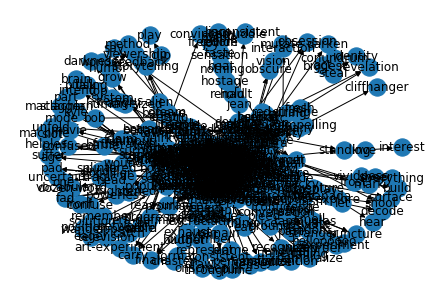

In [23]:
tv_pytextrank = pytextrank_summary('tv.json', 'tv1.json', 'tv2.json', 'tv3.json')

**excerpts:** Tour ’s dispensation as given to Steph Curry. Under Armour icon who plays off two – after the Warriors player was handed a sponsor ’s invitation. Golf should be accentuating its own blue-chip properties, not shipping them in from elsewhere. I ’ve had great times in my cricket career but at this stage golf is No1, ” he said. I always say cricket was my job and golf is my passion. Most cricketers would normally play a bit of golf socially but I ’m passionate about it. , There is no suggestion Curry has a career swap in mind. Obviously I want to play well and see how I handle tournament golf, ” Curry said. ”, This is not to say golf should shun celebrity.

**keywords:** steph curry, stage golf, this year, capable player, curry, basketball success, vanity project, misses, sports people, invitations, tournament golf, golf, tour


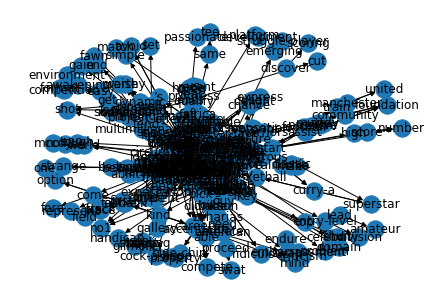

In [24]:
sports_pytextrank = pytextrank_summary('sports.json', 'sports1.json', 'sports2.json', 'sports3.json')

**excerpts:** Dishwasher Clean your dishwasher monthly to prevent a buildup of germs and maintain the efficiency of the machine — Next, deodorize the machine by sprinkling a cup of baking soda on the bottom of the tub and running the dishwasher on a half-cycle with hot water. Afterward, leave your dishwasher open for a few hours to air it out. Pour out the solution, replace the filter and run clean water through the machine two more times. Wipe and deodorize shelves with a solution of warm water and baking soda ( 1 tablespoon baking soda mixed with 1 quart warm water ). Microwave Fill a microwave-safe cup or bowl with about one cup of water.

**keywords:** soda, safe temperature, clean water, butter, dishwasher clean, hot water, tablespoon baking soda, refrigerators, top shelf, pyrex measuring cup, germs, cutup lemon, machine washing machines


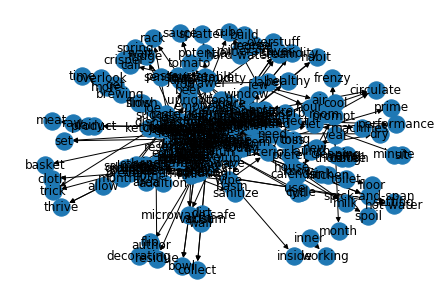

In [25]:
life_pytextrank = pytextrank_summary('life.json', 'life1.json', 'life2.json', 'life3.json')

### GenSim

The gensim summarizer is yet another approach to extractively summarizing blocks of text. The gensim summarizer is very similar to PyTextRank, with another layer of optimization in the form of the ranking algorithm described in this [paper](https://raw.githubusercontent.com/summanlp/docs/master/articulo/articulo-en.pdf) by Barrios et al. This ranking algorithm - named BM25 - is described as a variation of the tfidf model and is used to weight the graph generated by TextRank.

In [26]:
from gensim.summarization import summarize
from gensim.summarization import keywords

C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [27]:
# define a quick cleaining function to get rid of some of the messiness
def clean_it(file_name):
    file = open(file_name, 'r')
    filedata = file.readlines()
    split = filedata[0].split()
    rejoin = ' '.join(split)
    
    return rejoin

In [28]:
tv_text = clean_it('tv.txt')

In [29]:
tv_gensim = summarize(tv_text, ratio=0.03)
tv_gensim

'In the second season finale, back in 1991, the spirit of series-defining murder victim Laura Palmer told FBI special agent and series protagonist Dale Cooper, “I’ll see you again in 25 years.” That clip plays again in the first episode of Lynch’s Twin Peaks revival, as a reminder that decades have in fact gone by, Laura’s promise has been carried out, and a series canceled mid-story is back on the air.\nAs more details emerged in the Laura Palmer murder case, another victim surfaced, and the supernatural side of the story emerged, Twin Peaks stopped sending Cooper on wacky cosplay adventures to Canada, and letting him vet his clues with oddball psychic experiments.'

In [30]:
sport_text = clean_it('sports.txt')

In [31]:
sports_gensim = summarize(sport_text, ratio=0.1)
sports_gensim

'The Ellie Mae Classic in California will feature Curry – a basketball superstar and Under Armour icon who plays off two – after the Warriors player was handed a sponsor’s invitation.\n“I’ve had great times in my cricket career but at this stage golf is No1,” he said.\nMost cricketers would normally play a bit of golf socially but I’m passionate about it.” Which is all well and good but the concept of waltzing between sports is at best a strange one.\n“Obviously I want to play well and see how I handle tournament golf,” Curry said.'

In [32]:
life_text = clean_it('life.txt')

In [33]:
life_gensim = summarize(life_text, ratio=0.1)
life_gensim

'Pour distilled white vinegar into a dishwasher-safe cup (I usually use a two-cup Pyrex measuring cup), and place the cup upright on an empty dishwasher’s top rack.\nNext, deodorize the machine by sprinkling a cup of baking soda on the bottom of the tub and running the dishwasher on a half-cycle with hot water.\nPour out the solution, replace the filter and run clean water through the machine two more times.\nWhen you wash items in hot water, your machine is being cleaned as well, but once a month, you should still run an empty load with hot water and about a cup of distilled white vinegar to sanitize the basin and wipe out any lingering germs.'

### LexRank

The final summarization technique we'll take a look at is LexRank, which is also similar to TextRank. LexRank uses IDF-modified cosine similarity to measure the similarity between two sentences. Finally, LexRank adds a step after processing which excludes the top ranking sentences that are too similar to each other.

In [34]:
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer 
from sumy.summarizers.lex_rank import LexRankSummarizer

summarizer = LexRankSummarizer()

In [35]:
# read text into the parser as a string, apply LexRank to summarize
with open('tv.txt') as f:
    tv_text = f.read()

parser = PlaintextParser.from_string(tv_text, Tokenizer("english"))

lexrank_tv = summarizer(parser.document, 5)

for sentence in lexrank_tv:
    print(sentence)

In the second season finale, back in 1991, the spirit of series-defining murder victim Laura Palmer told FBI special agent and series protagonist Dale Cooper, “I’ll see you again in 25 years.” That clip plays again in the first episode of Lynch’s Twin Peaks revival, as a reminder that decades have in fact gone by, Laura’s promise has been carried out, and a series canceled mid-story is back on the air.
Like the audience, he was entranced by the town of Twin Peaks — its quirky people, its unexpected pleasures, the sheer vividness of everything around him.
As Twin Peaks developed, it became clear that it was about the maturing of a hero, but it was also about how the vast and incomprehensible aspects of his world claimed, consumed, and broke him.
And so are we.
For now, he’s just along for the ride.


In [36]:
# the lazy way of transforming our lexrank summaries into a string for analysis
tv_lexrank = "In the second season finale, back in 1991, the spirit of series-defining murder victim Laura Palmer told FBI special agent and series protagonist Dale Cooper, “I’ll see you again in 25 years.” That clip plays again in the first episode of Lynch’s Twin Peaks revival, as a reminder that decades have in fact gone by, Laura’s promise has been carried out, and a series canceled mid-story is back on the air. Like the audience, he was entranced by the town of Twin Peaks — its quirky people, its unexpected pleasures, the sheer vividness of everything around him. As Twin Peaks developed, it became clear that it was about the maturing of a hero, but it was also about how the vast and incomprehensible aspects of his world claimed, consumed, and broke him. And so are we. For now, he’s just along for the ride."

In [37]:
with open('sports.txt') as f:
    sports_text = f.read()
    
parser = PlaintextParser.from_string(sports_text, Tokenizer("english"))

lexrank_sports = summarizer(parser.document, 5)

for sentence in lexrank_sports:
    print(sentence)

Golden State Warriors are locked in a fierce play-off battle when Jordan Spieth – inspired by his brother’s basketball success and a capable player in his own right – decides he wants to feature in match five.
The Ellie Mae Classic in California will feature Curry – a basketball superstar and Under Armour icon who plays off two – after the Warriors player was handed a sponsor’s invitation.
“I’ve had great times in my cricket career but at this stage golf is No1,” he said.
The dynamics of a sponsor’s invitation also means he is not removing any other player’s place in the field.
“Sad.” It is difficult to see what can be gained.


In [38]:
sports_lexrank = "Golden State Warriors are locked in a fierce play-off battle when Jordan Spieth – inspired by his brother’s basketball success and a capable player in his own right – decides he wants to feature in match five. The Ellie Mae Classic in California will feature Curry – a basketball superstar and Under Armour icon who plays off two – after the Warriors player was handed a sponsor’s invitation. “I’ve had great times in my cricket career but at this stage golf is No1,” he said. The dynamics of a sponsor’s invitation also means he is not removing any other player’s place in the field. “Sad.” It is difficult to see what can be gained."

In [39]:
with open('life.txt') as f:
    life_text = f.read()
    
parser = PlaintextParser.from_string(life_text, Tokenizer("english"))

lexrank_life = summarizer(parser.document, 5)

for sentence in lexrank_life:
    print(sentence)

Dishwasher Clean your dishwasher monthly to prevent a buildup of germs and maintain the efficiency of the machine — you want to make sure your dishes are clean!
Afterward, leave your dishwasher open for a few hours to air it out.
When you wash items in hot water, your machine is being cleaned as well, but once a month, you should still run an empty load with hot water and about a cup of distilled white vinegar to sanitize the basin and wipe out any lingering germs.
You should do this about once a month or, if there is a strong odor emanating from your disposal, more frequently.
Place the cup in the microwave and turn the microwave on high for about three minutes or until the water is very hot and the window is covered in steam.


In [40]:
life_lexrank = "Dishwasher Clean your dishwasher monthly to prevent a buildup of germs and maintain the efficiency of the machine — you want to make sure your dishes are clean! Afterward, leave your dishwasher open for a few hours to air it out. When you wash items in hot water, your machine is being cleaned as well, but once a month, you should still run an empty load with hot water and about a cup of distilled white vinegar to sanitize the basin and wipe out any lingering germs. You should do this about once a month or, if there is a strong odor emanating from your disposal, more frequently. Place the cup in the microwave and turn the microwave on high for about three minutes or until the water is very hot and the window is covered in steam."

# The Tricky Question of Evaluation

So, we've looked at some summaries and some summarizing techniques - and we've got several different summaries of the same articles in our back pocket. How do we analyze them? Perhaps the most straightforward way (if lacking in rigor), is to just read the summaries and compare them to the source material and see if it captures most of the meaning. This, however, takes time and ultimately the goal of this whole process was to minimize the time we take reading through blocks of text.

## ROUGE
Instead, we turn to one of the popular methods of analyzing summaries: n-grams and ROUGE. N-grams refer to a sequence of n items from a document - in our case, from news articles. These items can be any component of that document - phonemes, letters, words, word pairs, etc. Because our articles are somewhat lengthy, it makes the most sense for us to look at words and word pairs.

To that end, we turn to ROUGE (or Recall-Oriented Understudy for Gisting Evaluation) to make sense of our n-grams. Essentially, it takes a look at words and word pairs and matches them with our human generated summary. Using our human generated summaries as a rubric, we match our words and word pairs to see which summary performs the best. A higher score indicates more similarity to the human generated summary - which we will use to compare different summarizing tools.

We'll focus on 3 subsections of the ROUGE metric: ROUGE-1, ROUGE-2, and ROUGE-L. ROUGE-1 compares the summary to reference text using unigrams, and ROUGE-2 makes that same comparison using bigrams. ROUGE-L is based on the longest common subsequence between the summary and reference text, which essentially identifies the longest co-occuring in sequence n-grams.

In [41]:
my_tv_summary = open('my_tv.txt')
my_tv_text = my_tv_summary.readlines()

my_sports_summary = open('my_sports.txt')
my_sports_text = my_sports_summary.readlines()

my_life_summary = open('my_life.txt')
my_life_text = my_life_summary.readlines()

In [42]:
from sumeval.metrics.rouge import RougeCalculator
rouge = RougeCalculator(stopwords=True, lang='en')

In [43]:
def calc_rouge(summary, reference):
    rouge_1 = rouge.rouge_n(summary=summary, references=reference, n=1)
    rouge_2 = rouge.rouge_n(summary=summary, references=reference, n=2)
    rouge_l = rouge.rouge_l(summary=summary, references=reference)
    
    return [rouge_1, rouge_2, rouge_l]

In [44]:
def easy_print_rouge(list_values, name):
    return print('{}\nROUGE-1: {}\nROUGE-2: {}\nROUGE-L: {}'.format(name, list_values[0], list_values[1], list_values[2]))

## Cosine Distance ROUGE Scores

In [45]:
tv_cos_rouge = calc_rouge(tv_cos, my_tv_text)
easy_print_rouge(tv_cos_rouge, 'TV Cosine Distance')

TV Cosine Distance
ROUGE-1: 0.2941176470588235
ROUGE-2: 0.0746268656716418
ROUGE-L: 0.1911764705882353


In [46]:
sports_cos_rouge = calc_rouge(sports_cos, my_sports_text)
easy_print_rouge(sports_cos_rouge, 'Sports Cosine Distance')

Sports Cosine Distance
ROUGE-1: 0.2191780821917808
ROUGE-2: 0.09722222222222222
ROUGE-L: 0.0958904109589041


In [47]:
life_cos_rouge = calc_rouge(life_cos, my_life_text)
easy_print_rouge(life_cos_rouge, 'Lifestyle Cosine Distance')

Lifestyle Cosine Distance
ROUGE-1: 0.2967741935483871
ROUGE-2: 0.0522875816993464
ROUGE-L: 0.2193548387096774


## Tfidf ROUGE Scores

In [48]:
tv_tfidf_rouge = calc_rouge(tv_tfidf, my_tv_text)
easy_print_rouge(tv_tfidf_rouge, 'TV Tfidf')

TV Tfidf
ROUGE-1: 0.3823529411764706
ROUGE-2: 0.208955223880597
ROUGE-L: 0.2647058823529411


In [49]:
sports_tfidf_rouge = calc_rouge(sports_tfidf, my_sports_text)
easy_print_rouge(sports_tfidf_rouge, 'Sports Tfidf')

Sports Tfidf
ROUGE-1: 0.18
ROUGE-2: 0
ROUGE-L: 0.1


In [50]:
life_tfidf_rouge = calc_rouge(life_tfidf, my_life_text)
easy_print_rouge(life_tfidf_rouge, 'Lifestyle Tfidf')

Lifestyle Tfidf
ROUGE-1: 0.38596491228070173
ROUGE-2: 0.15384615384615385
ROUGE-L: 0.19883040935672514


## PyTextRank ROUGE Scores

In [51]:
tv_pytextrank_rouge = calc_rouge(tv_pytextrank, my_tv_text)
easy_print_rouge(tv_pytextrank_rouge, 'TV PyTextRank')

TV PyTextRank
ROUGE-1: 0.3851851851851852
ROUGE-2: 0.15037593984962408
ROUGE-L: 0.2814814814814815


In [52]:
sports_pytextrank_rouge = calc_rouge(sports_pytextrank, my_sports_text)
easy_print_rouge(sports_pytextrank_rouge, 'Sports PyTextRank')

Sports PyTextRank
ROUGE-1: 0.2975206611570248
ROUGE-2: 0.1176470588235294
ROUGE-L: 0.2644628099173553


In [53]:
life_pytextrank_rouge = calc_rouge(life_pytextrank, my_life_text)
easy_print_rouge(life_pytextrank_rouge, 'Lifestyle PyTextRank')

Lifestyle PyTextRank
ROUGE-1: 0.31901840490797545
ROUGE-2: 0.07453416149068323
ROUGE-L: 0.2085889570552147


## GenSim ROUGE Scores

In [54]:
tv_gensim_rouge = calc_rouge(tv_gensim, my_tv_text)
easy_print_rouge(tv_gensim_rouge, 'TV GenSim')

TV GenSim
ROUGE-1: 0.34532374100719426
ROUGE-2: 0.1751824817518248
ROUGE-L: 0.17266187050359713


In [55]:
sports_gensim_rouge = calc_rouge(sports_gensim, my_sports_text)
easy_print_rouge(sports_gensim_rouge, 'Sports GenSim')

Sports GenSim
ROUGE-1: 0.30357142857142855
ROUGE-2: 0.12727272727272726
ROUGE-L: 0.26785714285714285


In [56]:
life_gensim_rouge = calc_rouge(life_gensim, my_life_text)
easy_print_rouge(life_gensim_rouge, 'Lifestyle GenSim')

Lifestyle GenSim
ROUGE-1: 0.3478260869565217
ROUGE-2: 0.13836477987421386
ROUGE-L: 0.27329192546583847


## LexRank ROUGE Scores

In [57]:
tv_lexrank_rouge = calc_rouge(tv_lexrank, my_tv_text)
easy_print_rouge(tv_lexrank_rouge, 'TV LexRank')

TV LexRank
ROUGE-1: 0.3503649635036496
ROUGE-2: 0.17777777777777776
ROUGE-L: 0.18978102189781024


In [58]:
sports_lexrank_rouge = calc_rouge(sports_lexrank, my_sports_text)
easy_print_rouge(sports_lexrank_rouge, 'Sports LexRank')

Sports LexRank
ROUGE-1: 0.20800000000000002
ROUGE-2: 0.1138211382113821
ROUGE-L: 0.20800000000000002


In [59]:
life_lexrank_rouge = calc_rouge(life_lexrank, my_life_text)
easy_print_rouge(life_lexrank_rouge, 'Lifestyle LexRank')

Lifestyle LexRank
ROUGE-1: 0.445859872611465
ROUGE-2: 0.12903225806451613
ROUGE-L: 0.33121019108280253


## BLEU

The BLEU metric (or, bilingual evaluation understudy) is primarily a metric used to describe text that has been translated - but has use for us here when applied to a summary of a larger text. BLEU scores account for higher level n-grams; in our case 3-grams and 4-grams. As with the ROUGE metric the scores range from 0 to 1, with higher scores indicating a more accurate and true-to-human-produced summary.

In [60]:
from nltk.translate.bleu_score import corpus_bleu

In [61]:
def calc_bleu(summary, reference):
    reference = [[nltk.word_tokenize(reference[0])]]
    summary = [nltk.word_tokenize(summary)]
    bleu_1 = corpus_bleu(reference, summary, weights=(1, 0, 0, 0))
    bleu_2 = corpus_bleu(reference, summary, weights=(0.5, 0.5, 0, 0))
    bleu_3 = corpus_bleu(reference, summary, weights=(0.33, 0.33, 0.33, 0))
    bleu_4 = corpus_bleu(reference, summary, weights=(0.25, 0.25, 0.25, 0.25))
    
    return [bleu_1, bleu_2, bleu_3, bleu_4]

In [62]:
def easy_print_bleu(list_values, name):
    return print('{}\nBLEU-1: {}\nBLEU-2: {}\nBLEU-3: {}\nBLEU-4: {}'.format(name, list_values[0], list_values[1], list_values[2], list_values[3]))

## Cosine Distance BLEU Scores

In [63]:
tv_cos_bleu = calc_bleu(tv_cos, my_tv_text)
easy_print_bleu(tv_cos_bleu, 'TV Cosine Distance')

TV Cosine Distance
BLEU-1: 0.39198263091934776
BLEU-2: 0.19519646361165396
BLEU-3: 0.11558011949032154
BLEU-4: 0.06307100803422659


In [64]:
sports_cos_bleu = calc_bleu(sports_cos, my_sports_text)
easy_print_bleu(sports_cos_bleu, 'Sports Cosine Distance')

Sports Cosine Distance
BLEU-1: 0.3370786516853933
BLEU-2: 0.2092873162126183
BLEU-3: 0.1580451798275901
BLEU-4: 0.12904537029032861


In [65]:
life_cos_bleu = calc_bleu(life_cos, my_life_text)
easy_print_bleu(life_cos_bleu, 'Life Cosine Distance')

Life Cosine Distance
BLEU-1: 0.2553349641522572
BLEU-2: 0.11188575607025295
BLEU-3: 0.06497913101211414
BLEU-4: 0.032166480284065664


## Tfidf BLEU Scores

In [66]:
tv_tfidf_bleu = calc_bleu(tv_tfidf, my_tv_text)
easy_print_bleu(tv_tfidf_bleu, 'TV Tfidf')

TV Tfidf
BLEU-1: 0.3577012900547734
BLEU-2: 0.23029175321387432
BLEU-3: 0.16076319652475338
BLEU-4: 0.12072005119261286


In [67]:
sports_tfidf_bleu = calc_bleu(sports_tfidf, my_sports_text)
easy_print_bleu(sports_tfidf_bleu, 'Sports Tfidf')

C:\ProgramData\Anaconda3\lib\site-packages\nltk\translate\bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\ProgramData\Anaconda3\lib\site-packages\nltk\translate\bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\ProgramData\Anaconda3\lib\site-packages\nltk\translate\bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnin

Sports Tfidf
BLEU-1: 0.13703743016906247
BLEU-2: 3.5405607364260816e-155
BLEU-3: 2.5454101479339965e-204
BLEU-4: 5.690998490426158e-232


In [68]:
life_tfidf_bleu = calc_bleu(life_tfidf, my_life_text)
easy_print_bleu(life_tfidf_bleu, 'Life Tfidf')

Life Tfidf
BLEU-1: 0.3458832300254557
BLEU-2: 0.2016527447577564
BLEU-3: 0.1362027659149582
BLEU-4: 0.09373120912738551


## PyTextRank BLEU Scores

In [69]:
tv_pytextrank_bleu = calc_bleu(tv_pytextrank, my_tv_text)
easy_print_bleu(tv_pytextrank_bleu, 'TV PyTextRank')

TV PyTextRank
BLEU-1: 0.34718066387669183
BLEU-2: 0.1819085593353319
BLEU-3: 0.11438877541208306
BLEU-4: 0.07844220154449136


In [70]:
sports_pytextrank_bleu = calc_bleu(sports_pytextrank, my_sports_text)
easy_print_bleu(sports_pytextrank_bleu, 'Sports PyTextRank')

Sports PyTextRank
BLEU-1: 0.3527004055067
BLEU-2: 0.1975388212014975
BLEU-3: 0.1567299098914938
BLEU-4: 0.13191213780336244


In [71]:
life_pytextrank_bleu = calc_bleu(life_pytextrank, my_life_text)
easy_print_bleu(life_pytextrank_bleu, 'Life PyTextRank')

C:\ProgramData\Anaconda3\lib\site-packages\nltk\translate\bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\ProgramData\Anaconda3\lib\site-packages\nltk\translate\bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\ProgramData\Anaconda3\lib\site-packages\nltk\translate\bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnin

Life PyTextRank
BLEU-1: 0.24704169891171165
BLEU-2: 0.104485973480515
BLEU-3: 0.05736134416772605
BLEU-4: 1.1761263880373544e-78


## GenSim BLEU Scores

In [72]:
tv_gensim_bleu = calc_bleu(tv_gensim, my_tv_text)
easy_print_bleu(tv_gensim_bleu, 'TV GenSim')

TV GenSim
BLEU-1: 0.3331406096921793
BLEU-2: 0.20988487224907343
BLEU-3: 0.13760227205586775
BLEU-4: 0.10364857750972477


In [73]:
sports_gensim_bleu = calc_bleu(sports_gensim, my_sports_text)
easy_print_bleu(sports_gensim_bleu, 'Sports GenSim')

Sports GenSim
BLEU-1: 0.2522640514449844
BLEU-2: 0.12802956336009136
BLEU-3: 0.0948305037149447
BLEU-4: 0.07467688588480925


In [74]:
life_gensim_bleu = calc_bleu(life_gensim, my_life_text)
easy_print_bleu(life_gensim_bleu, 'Life GenSim')

Life GenSim
BLEU-1: 0.29236404719779585
BLEU-2: 0.16822976368705625
BLEU-3: 0.11473188604745373
BLEU-4: 0.08102516598482275


## LexRank BLEU Scores

In [75]:
tv_lexrank_bleu = calc_bleu(tv_lexrank, my_tv_text)
easy_print_bleu(tv_lexrank_bleu, 'TV LexRank')

TV LexRank
BLEU-1: 0.4289523371270352
BLEU-2: 0.25901318480482527
BLEU-3: 0.16631739833500553
BLEU-4: 0.12101471829992864


In [76]:
sports_lexrank_bleu = calc_bleu(sports_lexrank, my_sports_text)
easy_print_bleu(sports_lexrank_bleu, 'Sports LexRank')

Sports LexRank
BLEU-1: 0.2909304965978822
BLEU-2: 0.15300117171754002
BLEU-3: 0.10897811365445764
BLEU-4: 0.08402009036487963


In [77]:
life_lexrank_bleu = calc_bleu(life_lexrank, my_life_text)
easy_print_bleu(life_lexrank_bleu, 'Life LexRank')

Life LexRank
BLEU-1: 0.38327789333063306
BLEU-2: 0.2194349688598024
BLEU-3: 0.1505586762122542
BLEU-4: 0.1075027582088598


And here are all the scores gathered into tables for easier comparison between summarization styles.

In [78]:
columns = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'BLEU-1', 'BLEU-2', 'BLEU-3', 'BLEU-4']
tv_index = ['TV Cosine Distance', 'TV Tfidf', 'TV PyTextRank', 'TV GenSim', 'TV LexRank']
tv_array = np.array(tv_cos_rouge + tv_cos_bleu + tv_tfidf_rouge + tv_tfidf_bleu + tv_pytextrank_rouge + tv_pytextrank_bleu + tv_gensim_rouge + tv_gensim_bleu + tv_lexrank_rouge + tv_lexrank_bleu)
tv_reshape = tv_array.reshape(5,7)
tv_scores = pd.DataFrame(tv_reshape, index=tv_index, columns=columns).round(3)
tv_scores['Mean'] = tv_scores.mean(axis=1).round(3)
tv_scores

,ROUGE-1,ROUGE-2,ROUGE-L,BLEU-1,BLEU-2,BLEU-3,BLEU-4,Mean
TV Cosine Distance,0.294,0.075,0.191,0.392,0.195,0.116,0.063,0.189
TV Tfidf,0.382,0.209,0.265,0.358,0.230,0.161,0.121,0.247
TV PyTextRank,0.385,0.150,0.281,0.347,0.182,0.114,0.078,0.220
TV GenSim,0.345,0.175,0.173,0.333,0.210,0.138,0.104,0.211
TV LexRank,0.350,0.178,0.190,0.429,0.259,0.166,0.121,0.242


In [79]:
tv_scores.iloc[0,7]

0.189

In [80]:
sports_index = ['Sports Cosine Distance', 'Sports Tfidf', 'Sports PyTextRank', 'Sports GenSim', 'Sports LexRank']
sports_array = np.array(sports_cos_rouge + sports_cos_bleu + sports_tfidf_rouge + sports_tfidf_bleu + sports_pytextrank_rouge + sports_pytextrank_bleu + sports_gensim_rouge + sports_gensim_bleu + sports_lexrank_rouge + sports_lexrank_bleu)
sports_reshape = sports_array.reshape(5,7)
sports_scores = pd.DataFrame(sports_reshape, index=sports_index, columns=columns).round(3)
sports_scores['Mean'] = sports_scores.mean(axis=1).round(3)
sports_scores

,ROUGE-1,ROUGE-2,ROUGE-L,BLEU-1,BLEU-2,BLEU-3,BLEU-4,Mean
Sports Cosine Distance,0.219,0.097,0.096,0.337,0.209,0.158,0.129,0.178
Sports Tfidf,0.180,0.000,0.100,0.137,0.000,0.000,0.000,0.060
Sports PyTextRank,0.298,0.118,0.264,0.353,0.198,0.157,0.132,0.217
Sports GenSim,0.304,0.127,0.268,0.252,0.128,0.095,0.075,0.178
Sports LexRank,0.208,0.114,0.208,0.291,0.153,0.109,0.084,0.167


In [81]:
life_index = ['Life Cosine Distance', 'Life Tfidf', 'Life PyTextRank', 'Life GenSim', 'Life LexRank']
life_array = np.array(life_cos_rouge + life_cos_bleu + life_tfidf_rouge + life_tfidf_bleu + life_pytextrank_rouge + life_pytextrank_bleu + life_gensim_rouge + life_gensim_bleu + life_lexrank_rouge + life_lexrank_bleu)
life_reshape = life_array.reshape(5,7)
life_scores = pd.DataFrame(life_reshape, index=life_index, columns=columns).round(3)
life_scores['Mean'] = life_scores.mean(axis=1).round(3)
life_scores

,ROUGE-1,ROUGE-2,ROUGE-L,BLEU-1,BLEU-2,BLEU-3,BLEU-4,Mean
Life Cosine Distance,0.297,0.052,0.219,0.255,0.112,0.065,0.032,0.147
Life Tfidf,0.386,0.154,0.199,0.346,0.202,0.136,0.094,0.217
Life PyTextRank,0.319,0.075,0.209,0.247,0.104,0.057,0.000,0.144
Life GenSim,0.348,0.138,0.273,0.292,0.168,0.115,0.081,0.202
Life LexRank,0.446,0.129,0.331,0.383,0.219,0.151,0.108,0.252


In [82]:
#which summarizer performed the best?
mean_index = ['Cosine Distance', 'Tfidf', 'PyTextRank', 'GenSim', 'LexRank']
mean_columns = ['TV', 'Sports', 'Life']
mean_array = np.array([0.189, 0.178, 0.147, 0.247, 0.060, 0.217, 0.220, 0.217, 0.144, 0.211, 0.178, 0.202, 0.242, 0.167, 0.252])
mean_reshape = mean_array.reshape(5,3)
mean_scores = pd.DataFrame(mean_reshape, index=mean_index, columns=mean_columns)
mean_scores['Mean'] = mean_scores.mean(axis=1).round(3)
mean_scores

,TV,Sports,Life,Mean
Cosine Distance,0.189,0.178,0.147,0.171
Tfidf,0.247,0.060,0.217,0.175
PyTextRank,0.220,0.217,0.144,0.194
GenSim,0.211,0.178,0.202,0.197
LexRank,0.242,0.167,0.252,0.220


In [83]:
#which article was hardest to summarize?
article_index = ['TV', 'Sports', 'Life']
article_columns = ['Cosine Distance', 'Tfidf', 'PyTextRank', 'GenSim', 'LexRank']
article_array = np.array([tv_scores['Mean'], sports_scores['Mean'], life_scores['Mean']])
article_scores = pd.DataFrame(article_array, index=article_index, columns=article_columns)
article_scores['Mean'] = article_scores.mean(axis=1).round(3)

In [84]:
article_scores

,Cosine Distance,Tfidf,PyTextRank,GenSim,LexRank,Mean
TV,0.189,0.247,0.220,0.211,0.242,0.222
Sports,0.178,0.060,0.217,0.178,0.167,0.160
Life,0.147,0.217,0.144,0.202,0.252,0.192


## Conclusions

Not much in the way of conclusions can be drawn from this small subset of data that I've analyzed, but it is an interesting proof of concept and points the way towards some interesting questions to ask. The three articles were all chosen based on the challenge that I thought they'd present to the summarizer - the TV article is long and and employs some flowery language, the sports article spends a lot of time talking about basketball but is really focused on golf, and the lifestyle article is a shorter bullet-point style write up that spends equal time discussing each individual piece but not much time discussing the overall theme.

With that in mind, let's take a look at the best performers for each article and try to reason why they could have performed well. For our TV article, Tfidf and LexRank both performed admirably - perhaps because they both take advantage of inverse document frequency in calculating similarity. When digesting particularly long articles, they would presumably have enough data to exclude some of the more common sentences and really hone in on the important sentences that contain most of the article's content.

In our article about sports the trick thrown at the summarizers is that the subject of basketball is important to the discussion the author is having, but is ultimately something of a red herring. PyTextRank is head and shoulders above the rest for this article, and this may be due to the fact that it accounts for semantics and the way words relate to each other a little bit more than the other extractive summarization methods.

Finally, for our lifestyle article, it would seem that LexRank is the top performer. It's tough to posit why exactly it performed better than our other summarizing tools - but again Tfidf and LexRank are not to far away from each other in their scoring. Perhaps these methods are well suited to the challenge the bullet-pointed, condensed style articles present.